In [17]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import pandas as pd

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [18]:
import pathlib
data_dir = pathlib.Path("./train/")
data_dir_val = pathlib.Path("./test/")

In [19]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

batch_size = 17 # Divisors of number 1156: 1, 2, 4, 17, 34, 68, 289, 578, 1156
img_height = 180
img_width = 180

1156


In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    # seed=12,
)

Found 1156 files belonging to 9 classes.


In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_val,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  # seed=24,
  )

Found 502 files belonging to 9 classes.


In [22]:
class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1156).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# normalization_layer = layers.Rescaling(1./255)

# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# print(np.min(first_image), np.max(first_image))

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


In [23]:
num_classes = len(class_names)
epochs = 30
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu',padding='same'),
    layers.MaxPooling2D(),
    # layers.Conv2D(64, 3, activation='relu',padding='same'),
    # layers.MaxPooling2D(),
    # layers.Dropout(0.2,seed=48),
    layers.Flatten(),
    # layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64800)            

In [24]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  # shuffle=False
)

Epoch 1/30
68/68 [==============================] - 15s 194ms/step - loss: 2.0258 - accuracy: 0.2526 - val_loss: 1.4394 - val_accuracy: 0.3924
Epoch 2/30
68/68 [==============================] - 16s 235ms/step - loss: 1.2619 - accuracy: 0.5078 - val_loss: 1.1376 - val_accuracy: 0.5797
Epoch 3/30
68/68 [==============================] - 14s 209ms/step - loss: 0.8790 - accuracy: 0.6687 - val_loss: 0.8192 - val_accuracy: 0.6793
Epoch 4/30
68/68 [==============================] - 13s 198ms/step - loss: 0.6368 - accuracy: 0.7881 - val_loss: 0.6684 - val_accuracy: 0.7410
Epoch 5/30
68/68 [==============================] - 13s 197ms/step - loss: 0.4984 - accuracy: 0.8209 - val_loss: 0.7384 - val_accuracy: 0.7191
Epoch 6/30
68/68 [==============================] - 14s 201ms/step - loss: 0.3634 - accuracy: 0.8763 - val_loss: 0.4704 - val_accuracy: 0.8307
Epoch 7/30
68/68 [==============================] - 14s 201ms/step - loss: 0.2763 - accuracy: 0.9066 - val_loss: 0.4518 - val_accuracy: 0.8446

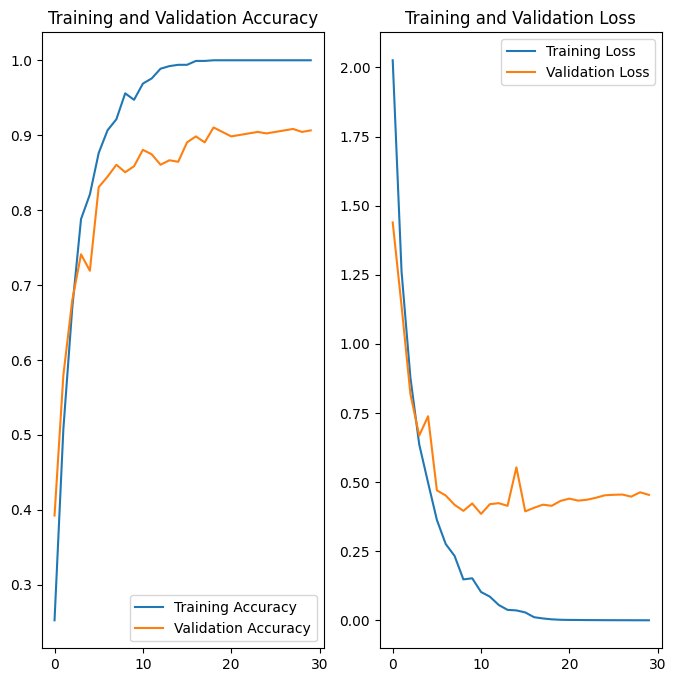

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
predicted = []
true_labels = []
dirs = list(data_dir_val.glob('*'))

for d in range(len(dirs)):
    dir = dirs[d]
    predicted.append([])

    for image in dir.glob('*/'):
        image = PIL.Image.open(image).resize((180, 180))
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        result = np.argmax(score)
        predicted[d].append(result)
        true_labels.append(d)

1/1 [==============================] - 0s 31ms/step


In [27]:
confusion_matrix = []
for l in range(len(predicted)):
    confusion_matrix.append([])
    for i in range(len(predicted)):
        confusion_matrix[l].append(predicted[l].count(i))

In [28]:
flat_predicted = [item for sublist in predicted for item in sublist]

print("Accuracy:", accuracy_score(true_labels, flat_predicted))

Accuracy: 0.8924302788844621


In [29]:
print(classification_report(true_labels, flat_predicted,target_names=class_names))

              precision    recall  f1-score   support

        Ajwa       1.00      1.00      1.00        53
      Galaxy       0.94      0.84      0.89        57
     Medjool       1.00      0.85      0.92        41
     Meneifi       0.82      0.87      0.85        70
   NabtatAli       0.82      0.93      0.87        54
       Rutab       0.95      0.82      0.88        44
     Shaishe       0.93      0.96      0.94        52
      Sokari       0.87      0.90      0.88        80
      Sugaey       0.81      0.84      0.83        51

    accuracy                           0.89       502
   macro avg       0.90      0.89      0.90       502
weighted avg       0.90      0.89      0.89       502



<AxesSubplot: >

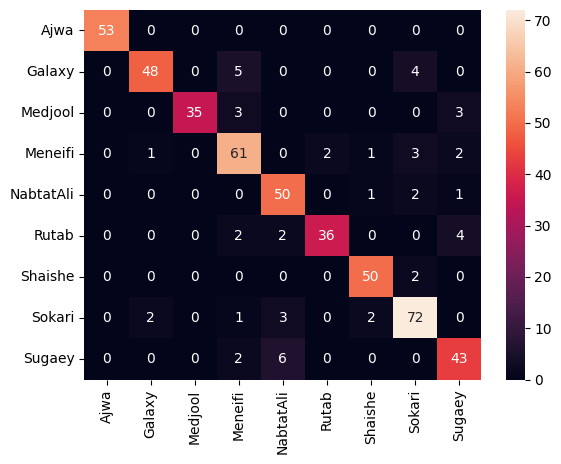

In [30]:
cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
sns.heatmap(cm_df, annot=True)

Text(0.5, 1.0, 'Number of images per class in training set')

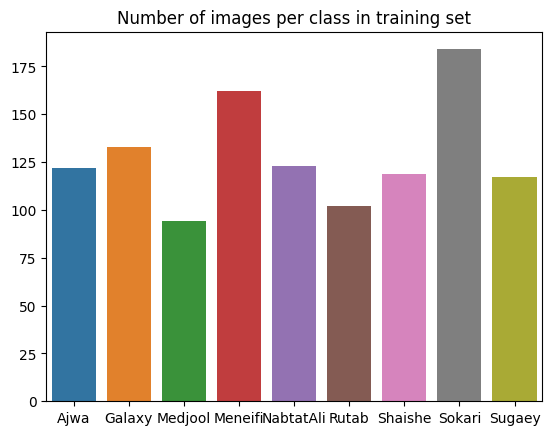

In [31]:
import os
classesNambers = []
ourClasses = []
rootdir = './train/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        x =d.split('/')
        # print(f'{x[-1]} => {len(os.listdir(d))}')
        classesNambers.append(len(os.listdir(d)))
        ourClasses.append(x[-1])

sns.barplot(x=ourClasses, y=classesNambers).set_title('Number of images per class in training set')

Text(0.5, 1.0, 'Number of images per class in test set')

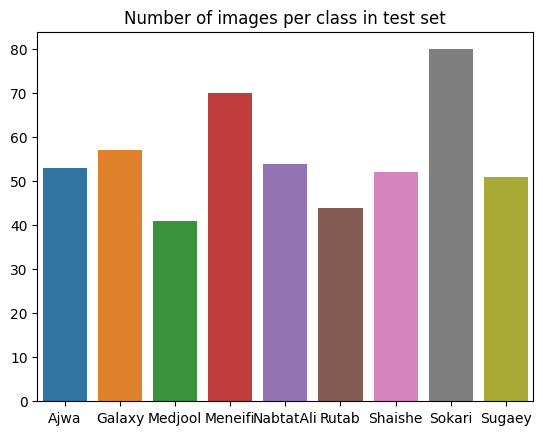

In [32]:
import os
classesNambers = []
ourClasses = []
rootdir = './test/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        x =d.split('/')
        # print(f'{x[-1]} => {len(os.listdir(d))}')
        classesNambers.append(len(os.listdir(d)))
        ourClasses.append(x[-1])

sns.barplot(x=ourClasses, y=classesNambers).set_title('Number of images per class in test set')